In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
test_data = torch.tensor((pd.read_csv("./testing_data_set_14_data.csv", header=None)).to_numpy(), dtype=torch.float32)
test_label = torch.tensor((pd.read_csv("./testing_data_set_14_labels.csv", header=None)).to_numpy()[:,0], dtype=torch.long)

val_data = torch.tensor((pd.read_csv("./validation_data_set_14_data.csv", header=None)).to_numpy(), dtype=torch.float32)
val_label = torch.tensor((pd.read_csv("./validation_data_set_14_labels.csv", header=None)).to_numpy()[:,0], dtype=torch.long)

train_data = torch.tensor((pd.read_csv("./training_data_set_14_labeled_data.csv", header=None)).to_numpy(), dtype=torch.float32)
train_label = torch.tensor((pd.read_csv("./training_data_set_14_labeled_labels.csv", header=None)).to_numpy()[:,0], dtype=torch.long)

train_unlabel = torch.tensor((pd.read_csv("./training_data_set_14_unlabeled.csv", header=None)).to_numpy(), dtype=torch.float32)

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.ReLU(),
            nn.Linear(hidden_dims[0], input_dim)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
        
def train_autoencoder(autoencoder, train_data, epochs=100, batch_size=50, lr=0.01, threshold=0.00001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters(), lr=lr)
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    prev_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            recon, _ = autoencoder(batch)
            loss = criterion(recon, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if abs(prev_loss - avg_loss) < threshold:
            print(f"Stopping early at epoch {epoch}, Loss change below threshold: {avg_loss}")
            break
        prev_loss = avg_loss
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss}")
    
    return autoencoder

In [4]:
class DFNN(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, hidden4, output_dim):
        super(DFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.fc5 = nn.Linear(hidden4, output_dim)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        x = self.fc5(x)
        return x

class DFNN_fine(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, hidden3, output_dim):
        super(DFNN_fine, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden3, output_dim)
    
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.fc4(x)
        return x

def train_dfnn(model, train_data, train_labels, epochs=100, batch_size=50, lr=0.01, threshold=0.0001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_dataset = data.TensorDataset(train_data, train_labels)
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    prev_loss = float('inf')
    
    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        if abs(prev_loss - avg_loss) < threshold:
            print(f"Stopping early at epoch {epoch}, Loss change below threshold: {avg_loss}")
            break
        prev_loss = avg_loss
        
        if epoch % 5 == 0:
            print(f"Epoch {epoch}, Loss: {avg_loss}")
    
    return model

In [5]:
def evaluate_model(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        predictions = model(test_data).argmax(dim=1)
    conf_mat = confusion_matrix(test_labels.cpu(), predictions.cpu())
    #print(conf_mat)
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [6]:
input_dim = 36
hidden_dims = [[28,24],[18,14],[10,8]]
hidden_dfnn = [24,10,8]
output_dim = 5

In [7]:
print("Training Autoencoders...")
ae1 = Autoencoder(input_dim, hidden_dims[0])
ae1 = train_autoencoder(ae1, train_unlabel)
train_unlabeled_data_encoded = ae1.encoder(train_unlabel).detach()

ae2 = Autoencoder(hidden_dims[0][1], hidden_dims[1])
ae2 = train_autoencoder(ae2, train_unlabeled_data_encoded)
train_unlabeled_data_encoded = ae2.encoder(train_unlabeled_data_encoded).detach()

ae3 = Autoencoder(hidden_dims[1][1], hidden_dims[2])
ae3 = train_autoencoder(ae3, train_unlabeled_data_encoded)
train_unlabeled_data_encoded = ae3.encoder(train_unlabeled_data_encoded).detach()

w11 = ae1.encoder[0].weight #1
w12 = ae1.encoder[2].weight
w21 = ae2.encoder[0].weight
w22 = ae2.encoder[2].weight
w31 = ae3.encoder[0].weight
w32 = ae3.encoder[2].weight #4

y12 = torch.mm(w21, w12) #2
y23 = torch.mm(w31, w22) #3

#print(y12.shape)
#print(y23.shape)


print("Training Done")

Training Autoencoders...
Epoch 0, Loss: 0.009318509418517352
Epoch 5, Loss: 0.0036059720175606862
Epoch 10, Loss: 0.002836392813229135
Epoch 15, Loss: 0.0026279129620109284
Stopping early at epoch 19, Loss change below threshold: 0.002587506075256637
Epoch 0, Loss: 0.010392988419958523
Epoch 5, Loss: 0.001801876474304923
Stopping early at epoch 10, Loss change below threshold: 0.0010385690506414644
Epoch 0, Loss: 0.019711268533553396
Epoch 5, Loss: 0.0026968921734286206
Epoch 10, Loss: 0.0024639250211683766
Stopping early at epoch 11, Loss change below threshold: 0.0024736987027738776
Training Done


In [8]:
print("Training DFNN with no pretraining...")
dfnn_scratch = DFNN_fine(input_dim, hidden_dims[0][0], hidden_dims[1][0], hidden_dims[2][0], output_dim)
dfnn_scratch = train_dfnn(dfnn_scratch, train_data, train_label)

Training DFNN with no pretraining...
Epoch 0, Loss: 1.613935931523641
Epoch 5, Loss: 1.3858077605565389
Epoch 10, Loss: 1.2593040943145752
Epoch 15, Loss: 1.2253552357355753
Epoch 20, Loss: 1.1671890338261923
Epoch 25, Loss: 1.1131617744763693
Epoch 30, Loss: 1.1026610771814982
Epoch 35, Loss: 1.059334401289622
Epoch 40, Loss: 1.0402568022410075
Epoch 45, Loss: 1.0389545520146688
Epoch 50, Loss: 0.9887478748957316
Epoch 55, Loss: 0.978077483177185
Epoch 60, Loss: 0.9670421441396078
Epoch 65, Loss: 0.936317789554596
Epoch 70, Loss: 0.9005860726038615
Epoch 75, Loss: 0.8777705748875936
Epoch 80, Loss: 0.8683336496353149
Epoch 85, Loss: 0.8417970418930054
Epoch 90, Loss: 0.8255520939826966
Epoch 95, Loss: 0.792707089583079


In [9]:
pretrained_dfnn = DFNN(input_dim, hidden_dims[0][0], hidden_dims[1][0], hidden_dims[2][0], hidden_dims[2][1], output_dim)
pretrained_dfnn.fc1.weight.data = w11.data.clone()
pretrained_dfnn.fc2.weight.data = y12.data.clone()
pretrained_dfnn.fc3.weight.data = y23.data.clone()
pretrained_dfnn.fc4.weight.data = w32.data.clone()
pretrained_dfnn = train_dfnn(pretrained_dfnn, train_data, train_label)

v32 = pretrained_dfnn.fc4.weight
w0 = pretrained_dfnn.fc5.weight

v30 = torch.mm(w0, v32)

fine_tuned_dfnn = DFNN_fine(input_dim, hidden_dims[0][0], hidden_dims[1][0], hidden_dims[2][0], output_dim)
fine_tuned_dfnn.fc1.weight.data = w11.data.clone()
fine_tuned_dfnn.fc2.weight.data = y12.data.clone()
fine_tuned_dfnn.fc3.weight.data = y23.data.clone()
fine_tuned_dfnn.fc4.weight.data = v30.data.clone()
fine_tuned_dfnn = train_dfnn(fine_tuned_dfnn, train_data, train_label)

Epoch 0, Loss: 1.6127183119455972
Epoch 5, Loss: 1.2495160897572835
Epoch 10, Loss: 1.172363034884135
Epoch 15, Loss: 1.1268953919410705
Epoch 20, Loss: 1.1407214482625325
Epoch 25, Loss: 1.0977702538172405
Epoch 30, Loss: 1.0919971227645875
Epoch 35, Loss: 1.0260490854581197
Epoch 40, Loss: 1.0186212499936422
Epoch 45, Loss: 0.9721970518430074
Epoch 50, Loss: 0.9654472470283508
Epoch 55, Loss: 0.9543486316998799
Epoch 60, Loss: 0.9024978121121724
Epoch 65, Loss: 0.8893657644589742
Epoch 70, Loss: 0.9111432194709778
Epoch 75, Loss: 0.8326465288798014
Epoch 80, Loss: 0.830925707022349
Epoch 85, Loss: 0.8258116205533346
Epoch 90, Loss: 0.8007031559944153
Epoch 95, Loss: 0.7855660200119019
Epoch 0, Loss: 1.5261299053827921
Epoch 5, Loss: 1.1595012982686361
Epoch 10, Loss: 1.0847429116566976
Epoch 15, Loss: 1.0255563537279764
Epoch 20, Loss: 0.9827099283536275
Epoch 25, Loss: 0.9416611353556316
Epoch 30, Loss: 0.9409424225489299
Epoch 35, Loss: 0.8790648897488912
Epoch 40, Loss: 0.85132161

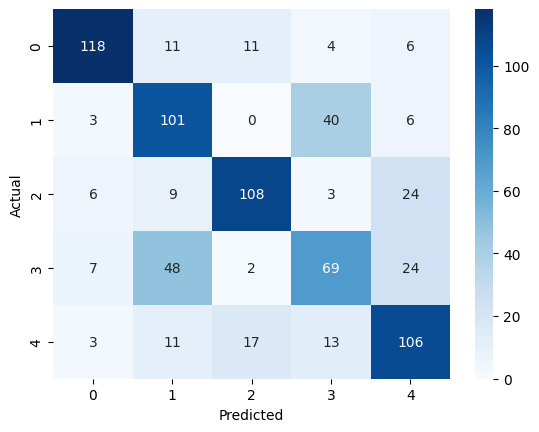

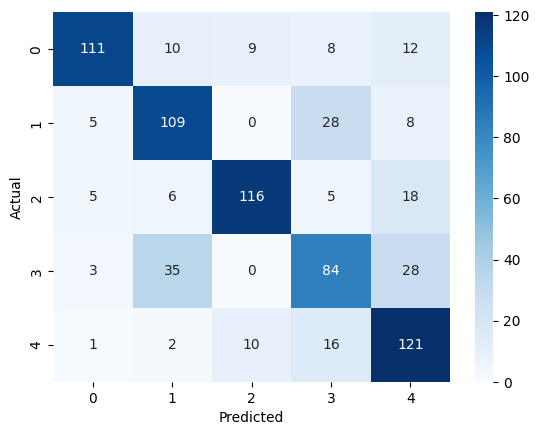

In [10]:
evaluate_model(dfnn_scratch, train_data, train_label)
evaluate_model(fine_tuned_dfnn, train_data, train_label)

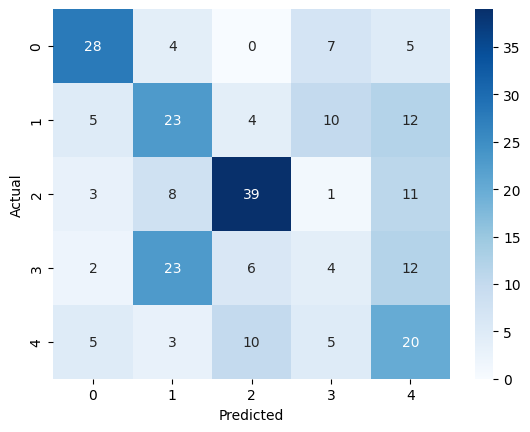

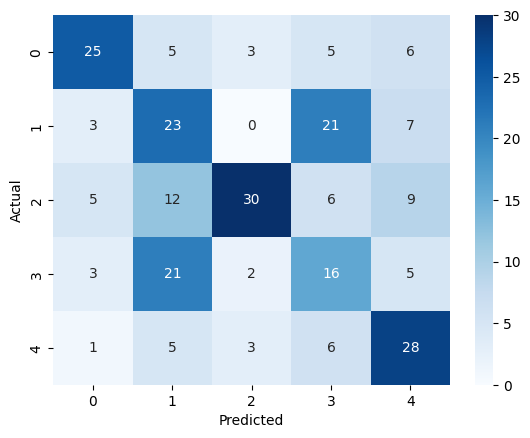

In [11]:
evaluate_model(dfnn_scratch, test_data, test_label)
evaluate_model(fine_tuned_dfnn, test_data, test_label)